In [1]:
import keras

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')


### Load Models, Metrics, Datasets


In [3]:
from attribution import compare_cases
from dataloader import fetch_datasets


models = {
    'nn':
    MLPClassifier(random_state=0),
#     'svm':
#     sklearn.svm.SVC(kernel='rbf', probability=True),
    'logit':
    sklearn.linear_model.LogisticRegression(),
    'rf':
    sklearn.ensemble.RandomForestClassifier(n_estimators=100,
                                            max_depth=None,
                                            min_samples_split=2,
                                            random_state=0),
    'knn':
    sklearn.neighbors.KNeighborsClassifier(),
    'gbc':
    sklearn.ensemble.GradientBoostingClassifier(random_state=0)
}

metrics = {
    'accuracy': lambda Y,Y_hat : accuracy_score(Y,Y_hat), 
    'f1': lambda Y,Y_hat : f1_score(Y,Y_hat,average='weighted', zero_division = 0), 
    'precision': lambda Y,Y_hat : precision_score(Y,Y_hat,average='weighted', zero_division = 0), 
    'recall': lambda Y,Y_hat : recall_score(Y,Y_hat,average='weighted', zero_division = 0), 
}


datasets = fetch_datasets()

### Gen Shap/ANWA. 

In [4]:
def run(datasets, metrics, models, load_from_disk = True):
    if load_from_disk:
        similarity_df = pd.read_csv('data/similarity.csv')
        granular_value_df = pd.read_csv('data/gran_value.csv')
        print('loaded from disk')
        return similarity_df, granular_value_df
    else:
        granular_value_df = pd.DataFrame()
        similarity_df = pd.DataFrame()
        for dataset_name, dataset in datasets.items():
            for metric_name, metric_func in metrics.items():
                print(f'dataset: {dataset_name}, metric: {metric_name}')
                logs, vals = compare_cases(dataset=(dataset_name, dataset),
                                           metric=(metric_name, metric_func),
                                           models = models)
                granular_value_df = granular_value_df.append(vals)
                similarity_df = similarity_df.append(logs)
        similarity_df.to_csv('data/similarity.csv')
        granular_value_df.to_csv('data/gran_value.csv')
        print('saved to disk')
        return similarity_df, granular_value_df


similarity_df, granular_value_df = run(datasets, metrics, models, False)


dataset: iris, metric: accuracy


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Jaccard Similarity

In [13]:
from sklearn.metrics import jaccard_score
from scipy.spatial import distance
# figure size in inches
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

acc = granular_value_df[granular_value_df['metric'] == 'accuracy']
# rankings = acc.groupby(['dataset', 'model', 'feature'], level = 0).rank(ascending=True, method='dense')
# acc['shap_rank'] = rankings['shap']
# acc['anwa_rank'] = rankings['anwa']
# acc.groupby(['dataset', 'model', 'feature']).sum().reset
ks = [1,2,3,4,5, 6, 7, 8,9,10]
Jaccards = []
for k in ks: 
    for keys in datasets.keys():
        if keys != 'iris':
            for model_key in models.keys():
                data_slice = acc[acc['dataset'] == keys]
                model_slice = data_slice[data_slice['model'] == model_key]
                top_k_shap = model_slice.nlargest(k, 'shap')['feature']
                top_k_anwa = model_slice.nlargest(k, 'anwa')['feature']
                jacc = distance.jaccard(top_k_shap, top_k_anwa)
                Jaccards.append((keys, model_key, k, jacc))

j = pd.DataFrame.from_dict(Jaccards)
j.columns = ['dataset', 'model', 'k', 'Jaccard_Sim']

sns.lineplot(x = 'k', y = 'Jaccard_Sim', hue = 'model', style = 'dataset', data = j)
plt.title('Jaccard Similarity by Model', size = 16)
plt.xlabel('K', size = 14)
plt.ylabel('Similarity', size = 14)
plt.legend(loc='lower right', fontsize='large', title_fontsize='28')
plt.show()

j[j['k'] == 10].mean()

NameError: name 'granular_value_df' is not defined

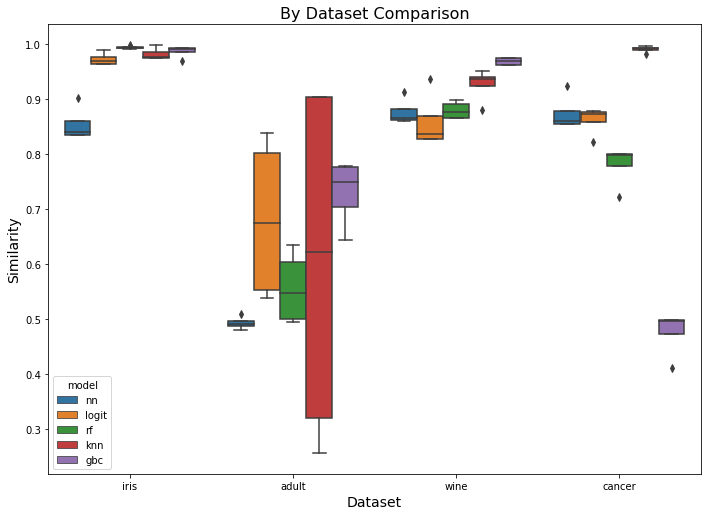

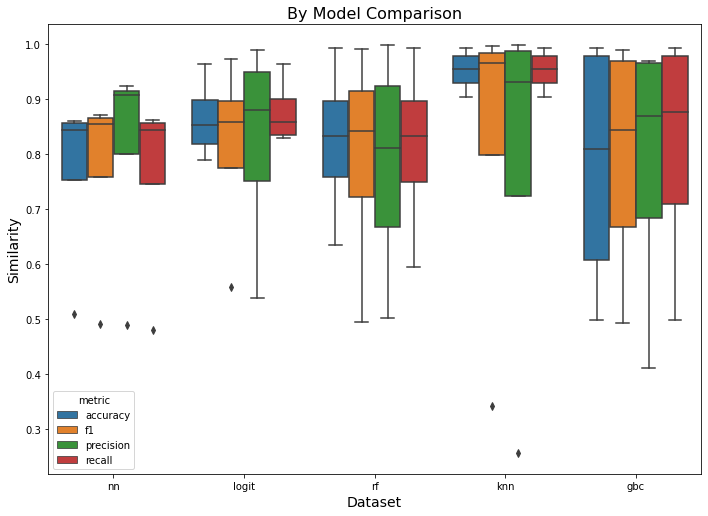

In [24]:
similarity_df.columns = ['dataset', 'model', 'metric', 'similarity']
sns.boxplot(x = 'dataset', y = 'similarity', hue = 'model',  data = similarity_df)
plt.title('By Dataset Comparison', size = 16)
plt.xlabel('Dataset', size = 14)
plt.ylabel('Similarity', size = 14)

plt.show()

sns.boxplot(x = 'model', y = 'similarity', hue = 'metric', data = similarity_df)
plt.title('By Model Comparison', size = 16)
plt.xlabel('Dataset', size = 14)
plt.ylabel('Similarity', size = 14)

plt.show()

# sns.boxplot(x = 'model', y = 'similarity',  data = similarity_df)

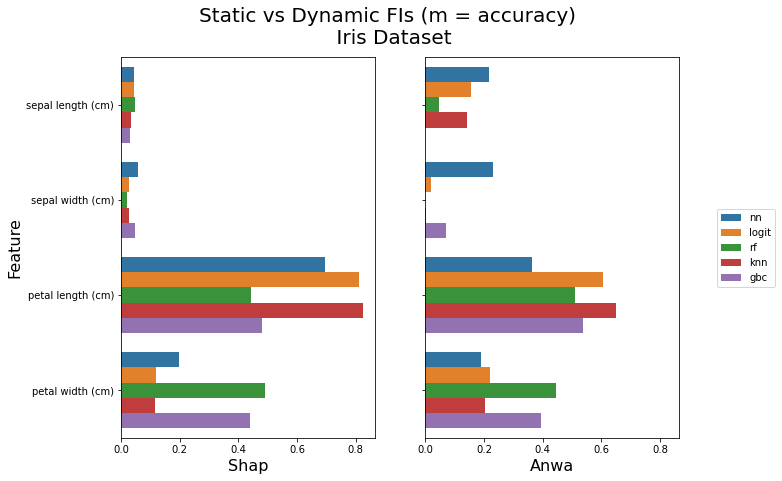

<Figure size 842.4x595.44 with 0 Axes>

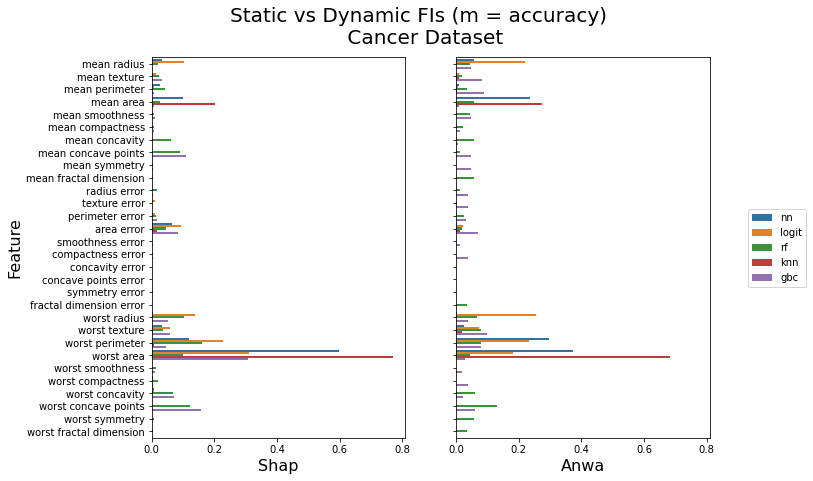

<Figure size 842.4x595.44 with 0 Axes>

In [59]:
temp = granular_value_df[granular_value_df['dataset'] == 'iris']
temp = temp[temp['metric'] == 'accuracy']
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=True, sharex=True)
fig.suptitle('Static vs Dynamic FIs (m = accuracy) \n Iris Dataset', size = 20)

# Bulbasaur
g = sns.barplot(ax=axes[0], x = 'shap', y = 'feature', hue = 'model', data = temp)
g.legend(loc='center right', bbox_to_anchor=(2.6, 0.5), ncol=1)# Charmander
g = sns.barplot(ax=axes[1], x = 'anwa', y = 'feature', hue = 'model', data = temp)
axes[0].set_xlabel('Shap',fontsize=16);
axes[0].set_ylabel('Feature',fontsize=16);
axes[1].set_xlabel('Anwa',fontsize=16);
axes[1].set_ylabel('',fontsize=16);

plt.legend([],[], frameon=False)
plt.show()
plt.savefig('sample.png')


temp = granular_value_df[granular_value_df['dataset'] == 'cancer']
temp = temp[temp['metric'] == 'accuracy']
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=True, sharex=True)
fig.suptitle('Static vs Dynamic FIs (m = accuracy) \n Cancer Dataset', size = 20)

# Bulbasaur
g = sns.barplot(ax=axes[0], x = 'shap', y = 'feature', hue = 'model', data = temp)
g.legend(loc='center right', bbox_to_anchor=(2.6, 0.5), ncol=1)# Charmander
g = sns.barplot(ax=axes[1], x = 'anwa', y = 'feature', hue = 'model', data = temp)
axes[0].set_xlabel('Shap',fontsize=16);
axes[0].set_ylabel('Feature',fontsize=16);
axes[1].set_xlabel('Anwa',fontsize=16);
axes[1].set_ylabel('',fontsize=16);
plt.legend([],[], frameon=False,fontsize='large', title_fontsize='28')
plt.show()
plt.savefig('sample.png')

### Multiple Sample Size analysis


In [5]:
from dataloader import fetch_datasets_adult_samples
models = {
    'nn':
    MLPClassifier(random_state=0),
#     'svm':
#     sklearn.svm.SVC(kernel='rbf', probability=True),
#     'logit':
#     sklearn.linear_model.LogisticRegression(),
#     'rf':
#     sklearn.ensemble.RandomForestClassifier(n_estimators=100,
#                                             max_depth=None,
#                                             min_samples_split=2,
#                                             random_state=0),
#     'knn':
#     sklearn.neighbors.KNeighborsClassifier(),
#     'gbc':
#     sklearn.ensemble.GradientBoostingClassifier(random_state=0)
}

metrics = {
    'accuracy': lambda Y,Y_hat : accuracy_score(Y,Y_hat), 
#     'f1': lambda Y,Y_hat : f1_score(Y,Y_hat,average='weighted', zero_division = 0), 
#     'precision': lambda Y,Y_hat : precision_score(Y,Y_hat,average='weighted', zero_division = 0), 
#     'recall': lambda Y,Y_hat : recall_score(Y,Y_hat,average='weighted', zero_division = 0), 
}


datasets = fetch_datasets_adult_samples()


def run(datasets, metrics, models, load_from_disk = True):
    if load_from_disk:
        similarity_df = pd.read_csv('data/similarity_adult.csv')
        granular_value_df = pd.read_csv('data/gran_value_adult.csv')
        print('loaded from disk')
        return similarity_df, granular_value_df
    else:
        
        granular_value_df = pd.DataFrame()
        similarity_df = pd.DataFrame()
        for dataset_name, dataset in datasets.items():
            for metric_name, metric_func in metrics.items():
                print(f'dataset: {dataset_name}, metric: {metric_name}')
                logs, vals = compare_cases(dataset=(dataset_name, dataset),
                                           metric=(metric_name, metric_func),
                                           models = models)
                granular_value_df = granular_value_df.append(vals)
                similarity_df = similarity_df.append(logs)
                similarity_df.to_csv('data/similarity_adult.csv')
                granular_value_df.to_csv('data/gran_value_adult.csv')
                print('saved to disk')
        return similarity_df, granular_value_df


similarity_df, granular_value_df = run(datasets, metrics, models, False)


dataset: adult_1000, metric: accuracy


  0%|          | 0/200 [00:00<?, ?it/s]

saved to disk
dataset: adult_2000, metric: accuracy


  0%|          | 0/400 [00:00<?, ?it/s]

saved to disk
dataset: adult_4000, metric: accuracy


  0%|          | 0/800 [00:00<?, ?it/s]

saved to disk
dataset: adult_8000, metric: accuracy


  0%|          | 0/1600 [00:00<?, ?it/s]

saved to disk
dataset: adult_16000, metric: accuracy


  0%|          | 0/3200 [00:00<?, ?it/s]

saved to disk
dataset: adult_32000, metric: accuracy


  0%|          | 0/6400 [00:00<?, ?it/s]

saved to disk


,dataset,model,metric,value
0,adult_1000,nn,accuracy,0.701029
0,adult_2000,nn,accuracy,0.564167
0,adult_4000,nn,accuracy,0.492878
0,adult_8000,nn,accuracy,0.742809
0,adult_16000,nn,accuracy,0.857294
0,adult_32000,nn,accuracy,0.870743


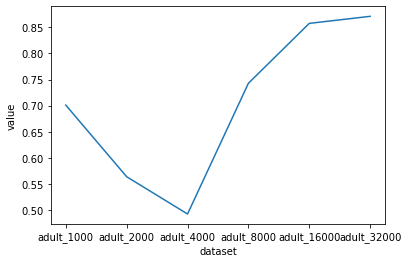

In [37]:
similarity_df.columns = ['dataset', 'model', 'metric', 'value']
sns.lineplot(x ='dataset', y ='value', data=similarity_df)

similarity_df

In [6]:
sns.regplot(x = [1000,2000,4000,8000,16000,32000], y= 'value', data = similarity_df)
plt.ylim = [0,1]
plt.show()
granular_value_df

KeyError: 'value'

In [36]:
temp = granular_value_df.melt(['feature', 'dataset'])
temp[temp['variable'] == 'shap' or 'anwa']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().